In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

In [2]:
with open('../config.json', 'r') as config_file:
    config = json.load(config_file)

df = pd.read_csv(os.path.join(config['data_path'], 'full_kpis.csv'))
print(df.shape)
df.head()

(12741835, 11)


,timestamp,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
0,2023-09-01 02:30:00,154_0_1,154,0,1,-102.50,78.0,0.829355,17.457447,18.521277,0
1,2023-09-01 02:30:00,154_1_1,154,1,1,-103.84,159.0,1.450913,27.500000,29.200000,0
2,2023-09-01 02:30:00,154_2_1,154,2,1,-104.92,60.0,0.746502,4.558011,4.795580,0
3,2023-09-01 02:30:00,162_0_0,162,0,0,-104.19,43.0,0.436677,84.500000,88.785714,0
4,2023-09-01 02:30:00,162_0_1,162,0,1,-103.93,48.0,0.519392,90.785714,96.428571,0


# Anomalies

## Alarm days

In [3]:
a_days = pd.read_csv(os.path.join(config['alogs'], 'anom_dates.csv'))
print(a_days.shape)
a_days.head()

(57, 1)


,date
0,2023-09-03
1,2023-09-04
2,2023-09-05
3,2023-09-06
4,2023-09-07


In [4]:
# Convert the 'date' column in a_days to datetime
a_days['date'] = pd.to_datetime(a_days['date'])

# Convert the 'timestamp' column in df to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a new column 'AnomalyDay' in df
df['AlarmDay'] = df['timestamp'].apply(lambda ts: ts.date()).isin(a_days['date'].dt.date).astype(int)

# Show stats for the 'AnomalyDay' column
df['AlarmDay'].value_counts()

AlarmDay
0    10917106
1     1824729
Name: count, dtype: int64

## Label anomalies

In [5]:
# Calculate the rolling mean and standard deviation for each cell
df['rolling_mean'] = df.groupby('cell')['minRSSI'].transform(lambda x: x.rolling(window=48*165, min_periods=1).mean())
df['rolling_std'] = df.groupby('cell')['minRSSI'].transform(lambda x: x.rolling(window=48*165, min_periods=1).std())

# Calculate the z-score for each minRSSI value
df['z_score'] = (df['minRSSI'] - df['rolling_mean']) / df['rolling_std']

# Create the 'anomaly' column based on the z-score and AlarmDay
df['anomaly'] = (df['z_score'].abs() >= 3).astype(int)

# Display the value counts for the 'anomaly' column
print(df['anomaly'].value_counts())

anomaly
0    12499987
1      241848
Name: count, dtype: int64


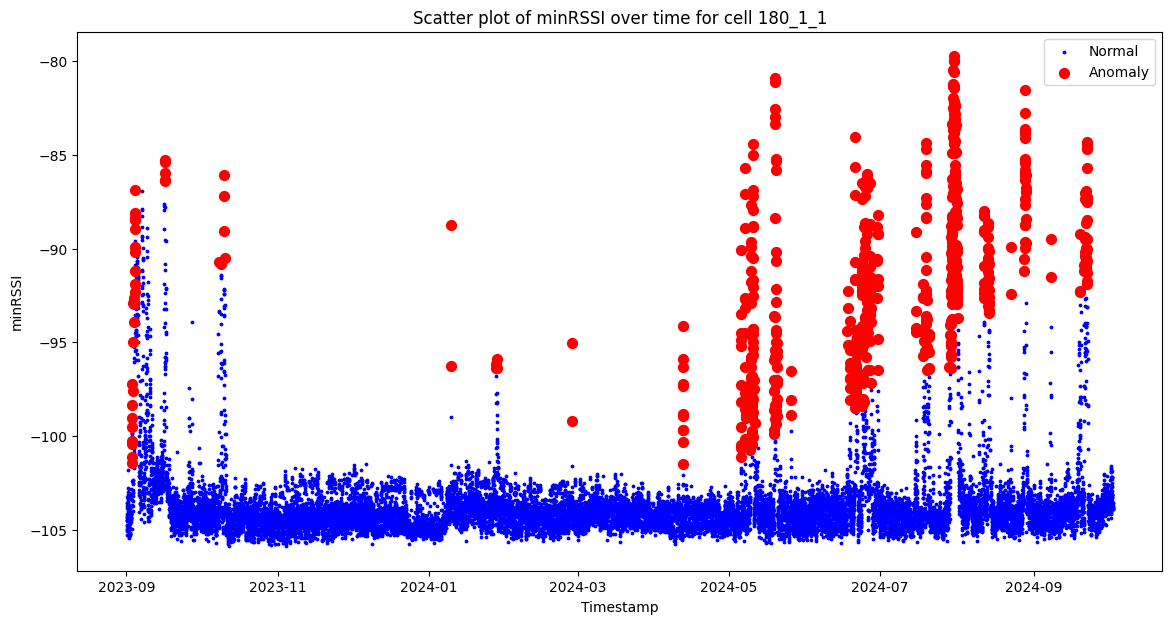

In [6]:
sample_cell = '180_1_1'
sample_df = df[df['cell'] == sample_cell]

# Scatter plot of minRSSI over time for the chosen cell
plt.figure(figsize=(14, 7))
plt.scatter(sample_df['timestamp'], sample_df['minRSSI'], c='blue', label='Normal', s=3)

# Mark anomalies with red
anomalies_sample = sample_df[sample_df['anomaly'] == 1]
plt.scatter(anomalies_sample['timestamp'], anomalies_sample['minRSSI'], c='red', label='Anomaly', s=50)

plt.xlabel('Timestamp')
plt.ylabel('minRSSI')
plt.title(f'Scatter plot of minRSSI over time for cell {sample_cell}')
plt.legend()
plt.show()

In [7]:
# Group by 'cell' and count the number of anomalies for each cell
anomaly_counts = df.groupby('cell')['anomaly'].sum()

# Sort the counts in ascending order and get the top 5 cells with the least anomalies
least_anomalies = anomaly_counts.nsmallest(5)

print(least_anomalies)

cell
565_0_1     3
186_0_1    13
576_0_1    24
536_0_1    27
349_1_1    31
Name: anomaly, dtype: int64


# Undersampling

In [8]:
def summary_stats(df):
    # Check if 'timestamp' is in datetime format, if not, convert it
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    warnings.filterwarnings('ignore')

    total_instances = len(df)
    total_anomalies = df['anomaly'].sum()
    anomaly_percentage = f"{(total_anomalies / total_instances) * 100:.4f} %" if total_instances > 0 else "0.00 %"
    total_cells = df['cell'].nunique()
    cells_with_anomalies = df['cell'][df['anomaly'] == 1].nunique()
    cell_anomaly_percentage = f"{(cells_with_anomalies / total_cells) * 100:.4f} %" if total_cells > 0 else "0.00 %"

    # Calculate total days using the unique dates derived from the timestamp
    total_days = df['timestamp'].dt.date.nunique()
    # Calculate days with anomalies by filtering the DataFrame
    days_with_anomalies = df.loc[df['anomaly'] == 1, 'timestamp'].dt.date.nunique()
    
    # Calculate the percentage of days with anomalies
    day_anomaly_percentage = f"{(days_with_anomalies / total_days) * 100:.4f} %" if total_days > 0 else "0.00 %"

    # Output the summary statistics
    return {
        'Total Instances': total_instances,
        'Total Anomalies': total_anomalies,
        'Anomaly Percentage': anomaly_percentage,
        'Total Cells': total_cells,
        'Cells with Anomalies': cells_with_anomalies,
        'Cells with Anomalies (pct)': cell_anomaly_percentage,
        'Total Days': total_days,
        'Days with Anomalies': days_with_anomalies,
        'Days with Anomalies (pct)': day_anomaly_percentage
    }

In [9]:
summary_stats(df)

{'Total Instances': 12741835,
 'Total Anomalies': 241848,
 'Anomaly Percentage': '1.8981 %',
 'Total Cells': 668,
 'Cells with Anomalies': 668,
 'Cells with Anomalies (pct)': '100.0000 %',
 'Total Days': 398,
 'Days with Anomalies': 398,
 'Days with Anomalies (pct)': '100.0000 %'}

In [10]:
df1 = df[df['AlarmDay'] == 1]
summary_stats(df1)

{'Total Instances': 1824729,
 'Total Anomalies': 114598,
 'Anomaly Percentage': '6.2803 %',
 'Total Cells': 668,
 'Cells with Anomalies': 665,
 'Cells with Anomalies (pct)': '99.5509 %',
 'Total Days': 57,
 'Days with Anomalies': 57,
 'Days with Anomalies (pct)': '100.0000 %'}

In [11]:
# Calculate the percentage of anomalies for each cell
anomaly_percentage = df1.groupby('cell')['anomaly'].mean() * 100

# Filter cells with anomaly percentage >= threshold
cells_to_keep = anomaly_percentage[anomaly_percentage >= 10].index

# Filter the dataframe to keep only the desired cells
filtered_df1 = df1[df1['cell'].isin(cells_to_keep)]

summary_stats(filtered_df1)

{'Total Instances': 395914,
 'Total Anomalies': 50580,
 'Anomaly Percentage': '12.7755 %',
 'Total Cells': 145,
 'Cells with Anomalies': 145,
 'Cells with Anomalies (pct)': '100.0000 %',
 'Total Days': 57,
 'Days with Anomalies': 53,
 'Days with Anomalies (pct)': '92.9825 %'}

In [12]:
# Calculate the number of samples for each cell in filtered_df1
cell_sample_counts = filtered_df1['cell'].value_counts().sort_values(ascending=False)
cell_sample_counts

cell
166_1_0    2734
182_0_0    2734
499_2_1    2734
499_2_0    2734
431_2_1    2734
           ... 
192_2_0    2730
343_2_1    2730
295_0_0    2613
295_1_0    2613
295_2_0    2613
Name: count, Length: 145, dtype: int64

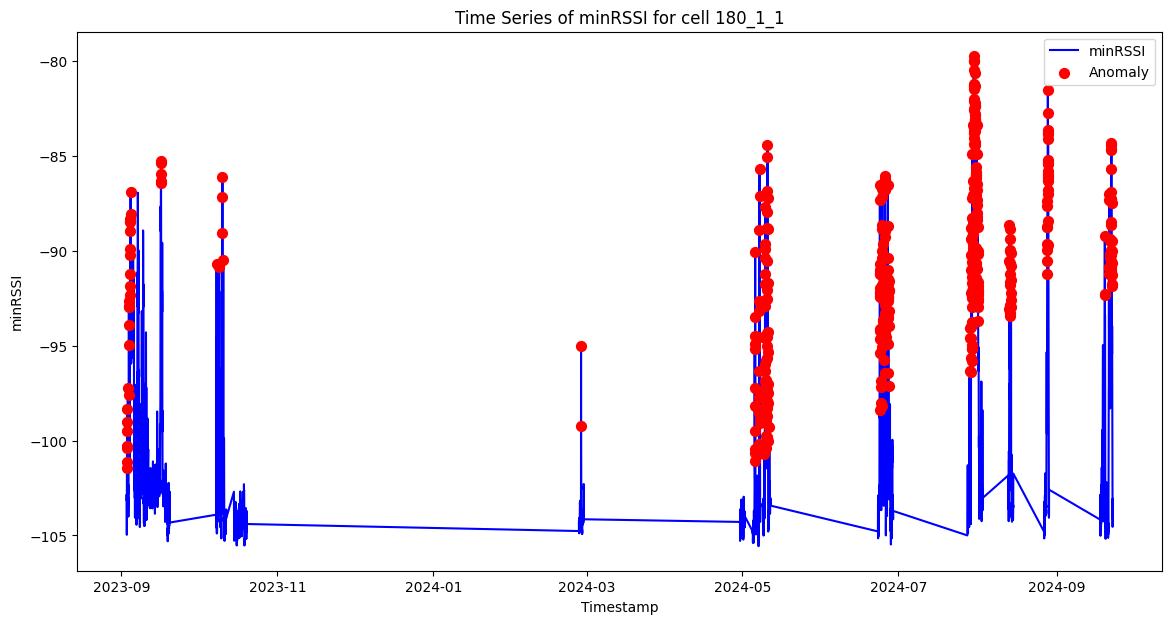

In [13]:
# Filter the sample cell data from filtered_df1
sample_cell_df = filtered_df1[filtered_df1['cell'] == sample_cell]

# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(sample_cell_df['timestamp'], sample_cell_df['minRSSI'], label='minRSSI', color='blue')

# Highlight the anomaly points
anomalies = sample_cell_df[sample_cell_df['anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['minRSSI'], color='red', label='Anomaly', s=50, zorder=5)

plt.xlabel('Timestamp')
plt.ylabel('minRSSI')
plt.title(f'Time Series of minRSSI for cell {sample_cell}')
plt.legend()
plt.show()

# Export

In [14]:
print(filtered_df1.shape)
filtered_df1.head()

(395914, 16)


,timestamp,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks,AlarmDay,rolling_mean,rolling_std,z_score,anomaly
60709,2023-09-03,166_1_0,166,1,0,-106.62,37.0,0.086723,8.362069,8.862069,0,1,-107.167174,0.280143,1.953198,0
60716,2023-09-03,168_1_1,168,1,1,-102.35,28.0,0.051203,6.545455,7.090909,0,1,-103.424783,0.470028,2.286635,0
60717,2023-09-03,168_2_0,168,2,0,-94.60,19.0,0.036644,8.866667,9.433333,0,1,-102.839130,2.233152,3.689463,1
60718,2023-09-03,168_2_1,168,2,1,-100.00,6.0,0.033116,0.000000,0.000000,0,1,-103.434022,0.890177,3.857683,1
60721,2023-09-03,174_2_1,174,2,1,-103.89,10.0,0.017862,61.000000,63.500000,0,1,-105.035326,0.714428,1.603137,0


In [16]:
filtered_df1 = filtered_df1.drop(columns=['AlarmDay', 'rolling_mean', 'rolling_std', 'z_score'])
print(filtered_df1.head())

       timestamp     cell  bts  antenna  carrier  minRSSI  pageSessions  \
60709 2023-09-03  166_1_0  166        1        0  -106.62          37.0   
60716 2023-09-03  168_1_1  168        1        1  -102.35          28.0   
60717 2023-09-03  168_2_0  168        2        0   -94.60          19.0   
60718 2023-09-03  168_2_1  168        2        1  -100.00           6.0   
60721 2023-09-03  174_2_1  174        2        1  -103.89          10.0   

          ULvol  sessionSetupDur  sessionDur  blocks  anomaly  
60709  0.086723         8.362069    8.862069       0        0  
60716  0.051203         6.545455    7.090909       0        0  
60717  0.036644         8.866667    9.433333       0        1  
60718  0.033116         0.000000    0.000000       0        1  
60721  0.017862        61.000000   63.500000       0        0  


In [17]:
df.to_csv(os.path.join(config['data_path'], 'cell_undersampled_2.csv'), index=False)